In [ ]:
%%writefile pypresent.py
class Present:
    def __init__(self, key, rounds=32):
        self.rounds = rounds
        if len(key) * 8 == 80:
            self.roundkeys = generateRoundkeys80(string2number(key), self.rounds)
        elif len(key) * 8 == 128:
            self.roundkeys = generateRoundkeys128(string2number(key), self.rounds)
        else:
            raise ValueError("Key must be a 128-bit or 80-bit rawstring")

    def encrypt(self, block):
        state = string2number(block)
        for i in range(self.rounds - 1):
            state = addRoundKey(state, self.roundkeys[i])
            state = sBoxLayer(state)
            state = pLayer(state)
        cipher = addRoundKey(state, self.roundkeys[-1])
        return number2string_N(cipher, 8)


Sbox = [0xc, 0x5, 0x6, 0xb, 0x9, 0x0, 0xa, 0xd, 0x3, 0xe, 0xf, 0x8, 0x4, 0x7, 0x1, 0x2]
Sbox_inv = [Sbox.index(x) for x in range(16)]
PBox = [
    0, 16, 32, 48, 1, 17, 33, 49, 2, 18, 34, 50, 3, 19, 35, 51,
    4, 20, 36, 52, 5, 21, 37, 53, 6, 22, 38, 54, 7, 23, 39, 55,
    8, 24, 40, 56, 9, 25, 41, 57, 10, 26, 42, 58, 11, 27, 43, 59,
    12, 28, 44, 60, 13, 29, 45, 61, 14, 30, 46, 62, 15, 31, 47, 63
]
PBox_inv = [PBox.index(x) for x in range(64)]


def generateRoundkeys80(key, rounds):
    roundkeys = []
    for i in range(1, rounds + 1):
        roundkeys.append(key >> 16)
        key = ((key & (2**19 - 1)) << 61) + (key >> 19)
        key = (Sbox[key >> 76] << 76) + (key & (2**76 - 1))
        key ^= i << 15
    return roundkeys


def generateRoundkeys128(key, rounds):
    roundkeys = []
    for i in range(1, rounds + 1):
        roundkeys.append(key >> 64)
        key = ((key & (2**67 - 1)) << 61) + (key >> 67)
        key = (Sbox[key >> 124] << 124) + (Sbox[(key >> 120) & 0xF] << 120) + (key & (2**120 - 1))
        key ^= i << 62
    return roundkeys


def addRoundKey(state, roundkey):
    return state ^ roundkey


def sBoxLayer(state):
    output = 0
    for i in range(16):
        output += Sbox[(state >> (i * 4)) & 0xF] << (i * 4)
    return output


def pLayer(state):
    output = 0
    for i in range(64):
        output += ((state >> i) & 0x01) << PBox[i]
    return output


def string2number(i):
    if isinstance(i, str):
        i = bytes(i, 'latin-1')
    return int(i.hex(), 16)


def number2string_N(i, N):
    s = '%0*x' % (N * 2, i)
    return bytes.fromhex(s)


Writing pypresent.py


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from pypresent import PresentA
from tqdm import tqdm
from PIL import Image
import os
import random


In [ ]:
# Load CIFAR-10
(x_train, y_train), (_, _) = cifar10.load_data()

# Generate 128-bit random key
key = os.urandom(16)
cipher = Present(key)

# Save the key for future use
with open("present_key.bin", "wb") as f:
    f.write(key)

# Encryption helper
def encrypt_image_np(img, cipher):
    flat_bytes = img.flatten().tobytes()
    pad_len = (8 - len(flat_bytes) % 8) % 8
    padded_bytes = flat_bytes + b'\x00' * pad_len

    encrypted_bytes = bytearray()
    for i in range(0, len(padded_bytes), 8):
        block = padded_bytes[i:i+8]
        encrypted_block = cipher.encrypt(block)
        encrypted_bytes.extend(encrypted_block)

    encrypted_array = np.frombuffer(encrypted_bytes, dtype=np.uint8)[:img.size]
    return encrypted_array.reshape(img.shape)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
save_dir = "/content/encrypted_images"
os.makedirs(save_dir, exist_ok=True)

encrypted_images = []
print("Encrypting and saving CIFAR-10 images...")

for idx, img in enumerate(tqdm(x_train)):
    enc_img = encrypt_image_np(img, cipher)
    encrypted_images.append(enc_img)

    # Save as PNG
    Image.fromarray(enc_img).save(f"{save_dir}/train_encrypted_{idx}.png")

encrypted_images = np.array(encrypted_images)
print("Encryption & saving complete!")


Encrypting and saving CIFAR-10 images...


100%|██████████| 50000/50000 [2:02:16<00:00,  6.82it/s]

Encryption & saving complete!


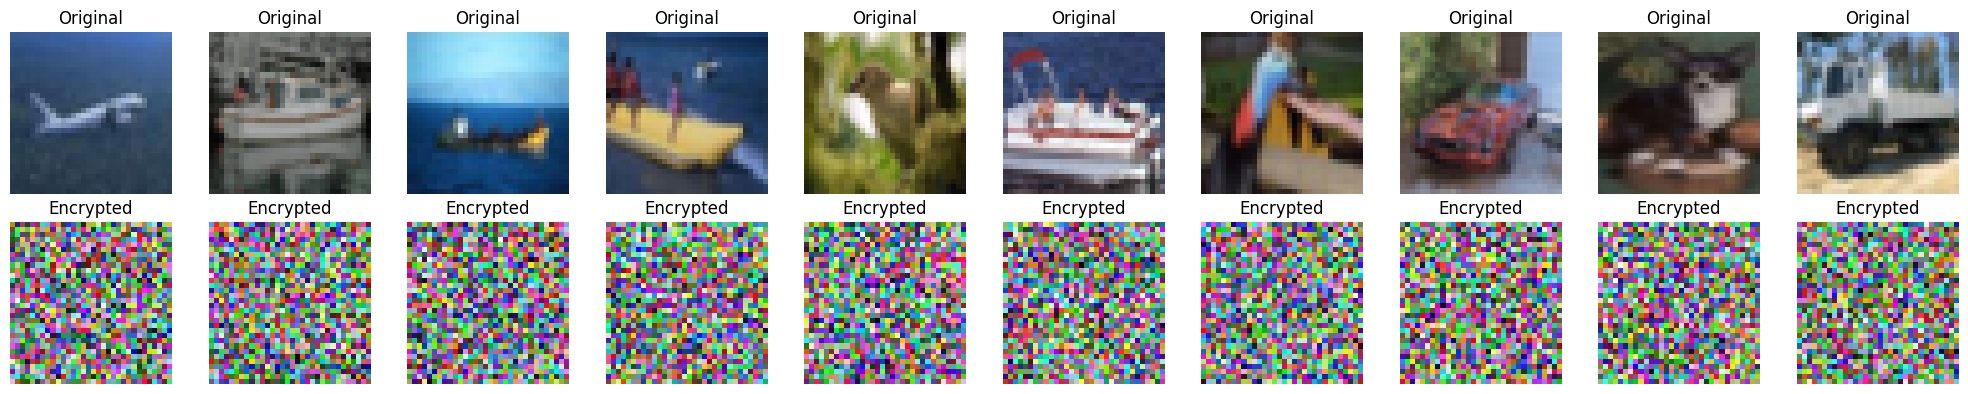

In [ ]:
# Display 10 random original vs encrypted images
plt.figure(figsize=(20, 4))
for i in range(10):
    idx = random.randint(0, len(x_train)-1)

    # Original
    plt.subplot(2, 10, i+1)
    plt.imshow(x_train[idx])
    plt.title("Original")
    plt.axis("off")

    # Encrypted
    plt.subplot(2, 10, i+11)
    plt.imshow(encrypted_images[idx])
    plt.title("Encrypted")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import shutil

# Zip the folder
shutil.make_archive("/content/encrypted_images", 'zip', "/content/encrypted_images")


'/content/encrypted_images.zip'

In [ ]:
from google.colab import files

# Download the zip
files.download("/content/encrypted_images.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>